In [21]:
# Details of the object under study

Object = 'SN2018oh'
#Host = 'UGC 3122'
#RA = '04:39:50.73'
#DEC = '+07:03:55.22'
z = 0.011
EB_V_Gal = 0.0369          # Na ID around maximum (Turatto 2003)
EB_V_Gal_err = 0.0027            # Schlafly & Finkbeiner 2011
EB_V_Host = 0.0
EB_V_Host_err = 0.0
DM = 33.61
DM_err = 0.05                 # modz  http://leda.univ-lyon1.fr/ledacat.cgi?o=PGC%20021381
B_maximum =  2458162.9

In [22]:

# Import packages and module
#--------------------------------------------------------------------------------#
import os
import glob
import numpy as np
import pandas as pd
from matplotlib import rcParams
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator


#--------------------------------------------------------------------------------#
%config InlineBackend.figure_format ='retina'

In [23]:
data_folder = '/Users/anirbandutta/Documents/SNEXP/Data/'

#--------------------------------------------------------------------------------#

lc_2006bt = data_folder + '2006bt_lc.txt'
lc_2011aa = data_folder + '2011aa_lc.txt'
lc_2012dn = data_folder + '2012dn_lc.txt'
lc_2017hpa = data_folder + '2017hpa_lc.txt'
lc_2018oh = data_folder + '2018oh_lc.txt'

#--------------------------------------------------------------------------------#

In [24]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

In [25]:
FILTER_directory = '/Users/anirbandutta/Dropbox/astromatic/'            # Filter information 
FILTER_data = FILTER_directory + 'FILTERS.dat'

In [26]:
# Read the filter file containing data on filters 

filter_df = pd.read_csv(FILTER_data, sep = '\s+')
filter_df = filter_df.replace('INDEF', np.nan).set_index(['FILTER', 'Marker', 'Color']).astype('float64')
filter_df = filter_df.reset_index().set_index('FILTER')
list_filters = filter_df.index.tolist()

In [27]:
# =============================================================================#
# Calculated in extinction_v1.py script using Fitzpatrick 1999 
# =============================================================================#
# This way gives us freedom to use different extinction law for Host

R_lambda_MW = {'uvw2': 8.80, 'uvm2': 9.31, 'uvw1': 6.63, 'uvu': 4.89, 'uvb': 4.12, 'uvv': 3.11,
               'U': 4.73, 'B': 4.09, 'V': 3.07, 'R': 2.44, 'I': 1.72, 'g': 3.72, 'r': 2.45, 'i': 1.91}

# Rv = 1.9
#R_lambda_HG = {'uvw2': 9.42, 'uvm2': 9.50, 'uvw1': 6.24, 'uvu': 3.78, 'uvb': 2.91, 'uvv': 1.90,
#               'U': 3.57, 'B': 2.88, 'V': 1.87, 'R': 1.28, 'I': 0.87}

R_lambda_HG = {'uvw2': 8.80, 'uvm2': 9.31, 'uvw1': 6.63, 'uvu': 4.89, 'uvb': 4.12, 'uvv': 3.11,
               'U': 4.73, 'B': 4.09, 'V': 3.07, 'R': 2.44, 'I': 1.72, 'g': 3.72, 'r': 2.45, 'i': 1.91}

# =============================================================================#

# =============================================================================#
# Calculate ZeroPoint
# =============================================================================#
Zeropoint = {'U': 4.18e-9, 'B': 6.32e-9, 'V': 3.63e-9, 'R': 2.18e-9, 'I': 1.13e-9,
            'uvw2': 5.36e-9, 'uvm2': 4.68e-9, 'uvw1': 4.15e-9, 'uvu': 3.63e-9, 'uvb': 6.48e-9,
            'uvv': 3.73e-9, 'g': 5.28e-9, 'r': 2.42e-9, 'i': 1.26e-9}


In [34]:
def plot_params(band, ax, ml_x, mil_x, ml_y, mil_y, invert=False):
    
    '''
    Remarks: Plotting parameters
    ax: axis object
    ml_x: major locator 'x'
    mil_x: minor locator 'x'
    ml_y: major locator 'y'
    mil_y: minor locator 'y'
    invert: Bool for the y-axis to be inverted 
    
    '''
    
    if invert:
        ax.invert_yaxis()
        
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    ax.tick_params(axis = 'both', which = 'major', direction = 'in', length = 12, width = 2.0, labelsize = 12)
    ax.tick_params(axis = 'both', which = 'minor', direction = 'in', length = 6, width = 1.2, labelsize = 12)
    ax.xaxis.set_major_locator(MultipleLocator(ml_x))
    ax.xaxis.set_minor_locator(MultipleLocator(mil_x))
    ax.yaxis.set_major_locator(MultipleLocator(ml_y))
    ax.yaxis.set_minor_locator(MultipleLocator(mil_y))
    


# Cell that contains all the important functions of the code


def group_similar_files(text_list, common_text, exceptions = ''):
    
    '''
    Remarks: A function to group similar kind of files in a directory.
    text_list: A text file used to store list of files
    common_text: A string (e.g. *.fits, *.list) used for grouping similar
    kinds of files
    exceptions: string of file name to exclude in grouping
    
    returns: list of grouped files
    '''
    
    list_files = glob.glob(common_text)
    if exceptions != '':
        list_exceptions = exceptions.split(',')
        for text in list_exceptions:
            list_files = filter(lambda x: not re.search(text, x), list_files)
        
    list_files.sort()
    if len(text_list) != 0:
        with open(text_list, 'w') as f:
            for file_name in list_files:
                f.write(file_name+'\n')
                
    return list_files   


def jd_to_date(jd, input_fmt='jd', output_fmt='isot'):
    
    '''
    Remarks: Convert jd to date
    jd: Input jd
    input_fmt: format of input ('jd')
    output_fmt: format of output ('iso', 'isot')
    returns: date
    '''
    
    from astropy.time import Time
    times = Time(jd, format=input_fmt)
    date_time = times.to_value(output_fmt)
    date = date_time.split('T')[0]
    
    return date

def apparent_mag_df(file_name, tempsub=False):
    
    
    '''
    Remarks: Creates an apparent magnitude dataframe
    file_name: file containing the SN magnitudes
    (JD, Filter, FMAG, FERR)
    tempsub: Whether the magnitudes are template subtracted
    returns: apparent magnitude dataframe
    '''
    
    appmag_df = pd.read_csv(file_name, sep = '\s+', engine = 'python')
    appmag_df = appmag_df.sort_values(by = ['FILTER', 'JD'], kind = 'mergesort')
    appmag_df = appmag_df[['JD','FILTER', 'FMAG', 'FERR']].reset_index(drop = True)
    
    return appmag_df

def columnwise_to_rowwise(name, data_df):
    
    '''
    Remarks: Change a dataframe in the form of (U,B,V,R,I) to 
    JD, FILTER, FMAG, FERR
    name: Name of the SN
    data_df: dataframe containing the UBVRI magnitudes.
    
    returns: output dataframe containing "Phase, Filter, Fmag, Ferr"
    Updates: Try this in pivot_table.
    '''
    
    ## List of column values to delete from a dataframe
    list_del = ['Date', 'Epoch', 'Seeing', 'EXPTIME', 'Y', 'YErr', 'J', 'JErr', 
           'H', 'HErr', 'K', 'KErr', 'g', 'gErr', 'r', 'rErr', 'i', 'iErr', 'Telescope']
    
    if 'Epoch' in data_df.columns.values:
        data_df['JD'] = data_df['JD'] + data_df['Epoch']
        
    #if 'Phase' not in data_df.columns:
    #    data_df['Phase'] = data_df['JD'] - SNdata_df.loc[name, 'B_maximum']
        
    
    data_df = data_df.set_index('JD')
    
    for column in list_del:
        if column in data_df.columns.values:
            data_df = data_df.drop(column, axis =1)
            
    data_arr = data_df.values
    size = data_arr.shape
    list_phase = np.repeat(data_df.index.values, (size[1]/2))
    list_filters = [x for x in data_df.columns.values if 'Err' not in x]
    data_arr = np.reshape(data_arr, [int(size[0]) * int(size[1]/2), 2])
    output_df = pd.DataFrame(data_arr, index = list_phase, columns = ['FMAG', 'FERR'])
    output_df.index.name = 'JD'
    output_df = output_df.reset_index(drop=False)
    output_df['FILTER'] = list_filters * size[0]
    output_df = output_df.replace('INDEF', np.nan).dropna(axis = 0, how = 'any')
    output_df = output_df[['JD', 'FILTER', 'FMAG', 'FERR']].reset_index(drop =True)
    output_df = output_df.sort_values(by = ['FILTER'], kind = 'mergesort')

    
    return output_df


def columnwise_to_rowwise1(name, data_df):
    
    '''
    Remarks: Change a dataframe in the form of (U,B,V,R,I) to 
    JD, FILTER, FMAG, FERR
    name: Name of the SN
    data_df: dataframe containing the UBVRI magnitudes.
    
    returns: output dataframe containing "Phase, Filter, Fmag, Ferr"
    Updates: Try this in pivot_table.
    '''
    
    ## List of column values to delete from a dataframe
#     list_del = ['Date', 'Epoch', 'Seeing', 'Phase', 'EXPTIME', 'Y', 'YErr', 'J', 'JErr', 
#            'H', 'HErr', 'K', 'KErr', 'g', 'gErr', 'r', 'rErr', 'i', 'iErr', 'Telescope']

    list_del = ['Date', 'Epoch', 'Seeing', 'EXPTIME', 'Y', 'YErr', 'J', 'JErr', 
                'H', 'HErr', 'K', 'KErr', 'g', 'gErr', 'r', 'rErr', 'i', 'iErr', 'Telescope']
    
    #if 'Epoch' in data_df.columns.values:
    #    data_df['JD'] = data_df['JD'] + data_df['Epoch']
        
    #if 'Phase' not in data_df.columns:
    #    data_df['Phase'] = data_df['JD'] - SNdata_df.loc[name, 'B_maximum']
        
    
    #data_df = data_df.set_index('JD')
    data_df = data_df.set_index('Phase')
    
    for column in list_del:
        if column in data_df.columns.values:
            data_df = data_df.drop(column, axis =1)
            
    #print (data_df)
            
    data_arr = data_df.values
    size = data_arr.shape
    list_phase = np.repeat(data_df.index.values, (size[1]/2))
    list_filters = [x for x in data_df.columns.values if 'Err' not in x]
    data_arr = np.reshape(data_arr, [int(size[0]) * int(size[1]/2), 2])
    output_df = pd.DataFrame(data_arr, index = list_phase, columns = ['FMAG', 'FERR'])
    output_df.index.name = 'Phase'
    output_df = output_df.reset_index(drop=False)
    output_df['FILTER'] = list_filters * size[0]
    output_df = output_df.replace('INDEF', np.nan).dropna(axis = 0, how = 'any')
    output_df = output_df[['Phase', 'FILTER', 'FMAG', 'FERR']].reset_index(drop =True)
    output_df = output_df.sort_values(by = ['FILTER'], kind = 'mergesort')

    
    return output_df

def calculate_dm(dist, dist_err):
    
    '''
    Remarks:
    dist: Distance
    dist_err: error in the measured distance
    Returns the value of Distance Modulus and Distance Modulus Error.

    The distance modulus is a measure of the distance to an object in magnitude units. 
    An object with a distance modulus of 'zero' is exactly 10 parsecs away. 
    If an object has a negative distance modulus( D.M.), that means 
    it is closer than 10 parsecs and if it has a positive D.M.
    that means it is farther than 10 parsec.

    m-M = 5*log(D)-5
    Here m-M is called the Distance Modulus. 
    
    m : apparent magnitude of the object
    M : absolute magnitude of the object
    D : Distance to the object in parsec

    '''
    
    distmod = 5*np.log10(dist*1e6) - 5
    distmod_err = (5 * 0.434 * dist_err)/dist
    
    return [distmod, distmod_err]

# -------------------------------------------------------------------------------- #

def calculate_dist(dist_mod, dist_modd_err):
    
    d = (10**((dist_mod+5)/5))/10**6
    d_err = (2.303 * d * dist_modd_err)/5
    
    return d, d_err

# -------------------------------------------------------------------------------- #

def calculate_zp(band):
    
    zp = -2.5*np.log10(Zeropoint[band]) - 21.100
    zp = round(zp, 3)
    
    return zp

def cal_flux(mag, err, band, name, ext_err=False):
    
    mag = float(mag)
    err = float(err)
    zp = calculate_zp(band)
    
    if name != '':
        dist = pd.to_numeric(SNdata_df.loc[name, 'Distance'])
        dist_err = pd.to_numeric(SNdata_df.loc[name, 'Distance_err'])
        ebv = pd.to_numeric(SNdata_df.loc[name, 'EB_V'])
        ebv_err = pd.to_numeric(SNdata_df.loc[name, 'EB_V_err'])
        
    else:
        dist, dist_err = calculate_dist(DM, DM_err)
        ebv_MW = EB_V_Gal
        ebv_HG = EB_V_Host
        
        if ext_err:
            ebv_err_MW = EB_V_err_Gal
            ebv_err_HG = EB_V_err_Host
        else:
            ebv_err_MW = 0.0
            ebv_err_HG = 0.0
        
    ##---------- Distance Modulus ----------##
    distmod = 5*np.log10(dist*1e6) - 5
    distmod_err = (5 * 0.434 * dist_err)/dist
    ##--------------------------------------##
    
    ##---------- Absolute Magnitude ----------##
    absmag = mag - (R_lambda_MW[band] * ebv_MW) - (R_lambda_HG[band] * ebv_HG) - distmod
    absmag_err = (err**2 + (R_lambda_MW[band] * ebv_err_MW)**2 + 
                  (R_lambda_HG[band] * ebv_err_HG)**2 + distmod_err**2)**0.5
    ##--------------------------------------##
    
    ##---------- Flux ----------##
    flux = 10**(-0.4 * (mag - (R_lambda_MW[band] * ebv_MW) - (R_lambda_HG[band] * ebv_HG) 
                        + zp + 21.10))
    flux_err = 2.303 * flux * (0.4 * (err**2 + (R_lambda_MW[band] * ebv_err_MW)**2 + 
                  (R_lambda_HG[band] * ebv_err_HG)**2))
    ##--------------------------------------##
    
    ##---------- Luminosity ----------##
    val_lum = float(flux) * 4 * np.pi * (3.086e24)**2
    luminosity = (val_lum)*dist**2
    luminosity_err = (8*np.pi*flux) * (dist) * (dist_err) * (3.086e24)**2
    ##--------------------------------------## 
    
    return float(absmag), float(absmag_err), float(flux), float(flux_err), \
            float(luminosity), float(luminosity_err)


def sn_abs_df(sn_df, name):
    
    '''
    Info: 
    data: the SN-dataframe under study.
    B_max: maximum magnitude in B-band.
    
    Returns: the absolute magnitude dataframe along with separate dataframes for 
    total, B, V, R, I, U
    Remarks: Future version will include itertuples.
    
    '''
    
    #sn_df = pd.read_csv(data, sep = '\s+', engine = 'python')
    #sn_df['Date'] = sn_df['JD'].apply(lambda x: jd_2_gcal(x))
    #sn_df['Phase'] = (sn_df['JD'] - B_maximum)/(1 + z)
    sn_df['FILTER'] = sn_df['FILTER'].apply(lambda x: x if 'UV' not in x else x.lower())

    for index, band in sn_df['FILTER'].items():
        if name != '':
            magflux = cal_flux(mag = sn_df.loc[index, 'FMAG'], 
                           err = sn_df.loc[index, 'FERR'], band = band, name = name)
        else:
            magflux = cal_flux(mag = sn_df.loc[index, 'FMAG'], 
                           err = sn_df.loc[index, 'FERR'], band = band, name = '')
        sn_df.loc[index, 'AbsMag'] = magflux[0]
        sn_df.loc[index, 'AbsErr'] = magflux[1]
        sn_df.loc[index, 'Flux'] = magflux[2]
        sn_df.loc[index, 'FluxErr'] = magflux[3]
        sn_df.loc[index, 'Lum'] = magflux[4]
        sn_df.loc[index, 'Lum_Err'] = magflux[5]
    
    return sn_df
                

In [29]:
object_df_UBVRI = pd.read_csv(lc_2018oh, sep='\s+', engine='python')

In [32]:
sn_df = columnwise_to_rowwise1(name='2011aa', data_df=object_df_UBVRI)

In [11]:
#sn_df = sn_df[sn_df['FMAG'] != 99.99]

In [33]:
sn_df

,Phase,FILTER,FMAG,FERR
0,-8.6,B,14.982,0.025
2,-8.5,B,14.940,0.026
7,-7.9,B,14.818,0.031
9,-7.5,B,14.789,0.031
11,-7.5,B,14.762,0.012
16,-7.2,B,14.758,0.027
19,-7.1,B,14.723,0.016
22,-6.9,B,14.691,0.043
26,-6.9,B,14.703,0.072
30,-6.5,B,14.666,0.022


In [36]:
flux_df_UBVRI = sn_abs_df(sn_df, name='')

In [14]:
flux_df_UBVRI = flux_df_UBVRI[(flux_df_UBVRI['FILTER'] != 'r') & (flux_df_UBVRI['FILTER'] != 'i')]

In [37]:
filepath = '/Users/anirbandutta/Documents/SNEXP/Sedona_Models_Proj/'
model1_lc = filepath + 'lc_model_5.out'

In [38]:
columns = ['Time', 'Lbol', 'Mbol', 'U', 'B', 'V', 'Cousins_R', 'Cousins_I', 'UVW1', 'UVM2', 'UVW2']
sedona_lc1_df = pd.read_csv(model1_lc, names=columns, 
                             sep='\s+', engine='python', skiprows=2, comment='#')
sedona_lc1_df['Phase'] = sedona_lc1_df['Time'].apply(lambda x: x - 19.5)

sedona_lc1_df['U_Vega'] = sedona_lc1_df['U'] - 0.79
sedona_lc1_df['B_Vega'] = sedona_lc1_df['B'] + 0.09
sedona_lc1_df['V_Vega'] = sedona_lc1_df['V'] - 0.02
sedona_lc1_df['R_Vega'] = sedona_lc1_df['Cousins_R'] - 0.21
sedona_lc1_df['I_Vega'] = sedona_lc1_df['Cousins_I'] - 0.45

In [39]:
sedona_lc1_df = sedona_lc1_df[(sedona_lc1_df['Time'] > 2.0) & (sedona_lc1_df['Time'] < 90)]

B
I
R
U
V


Text(0.5, 1.0, 'SN 2018oh')

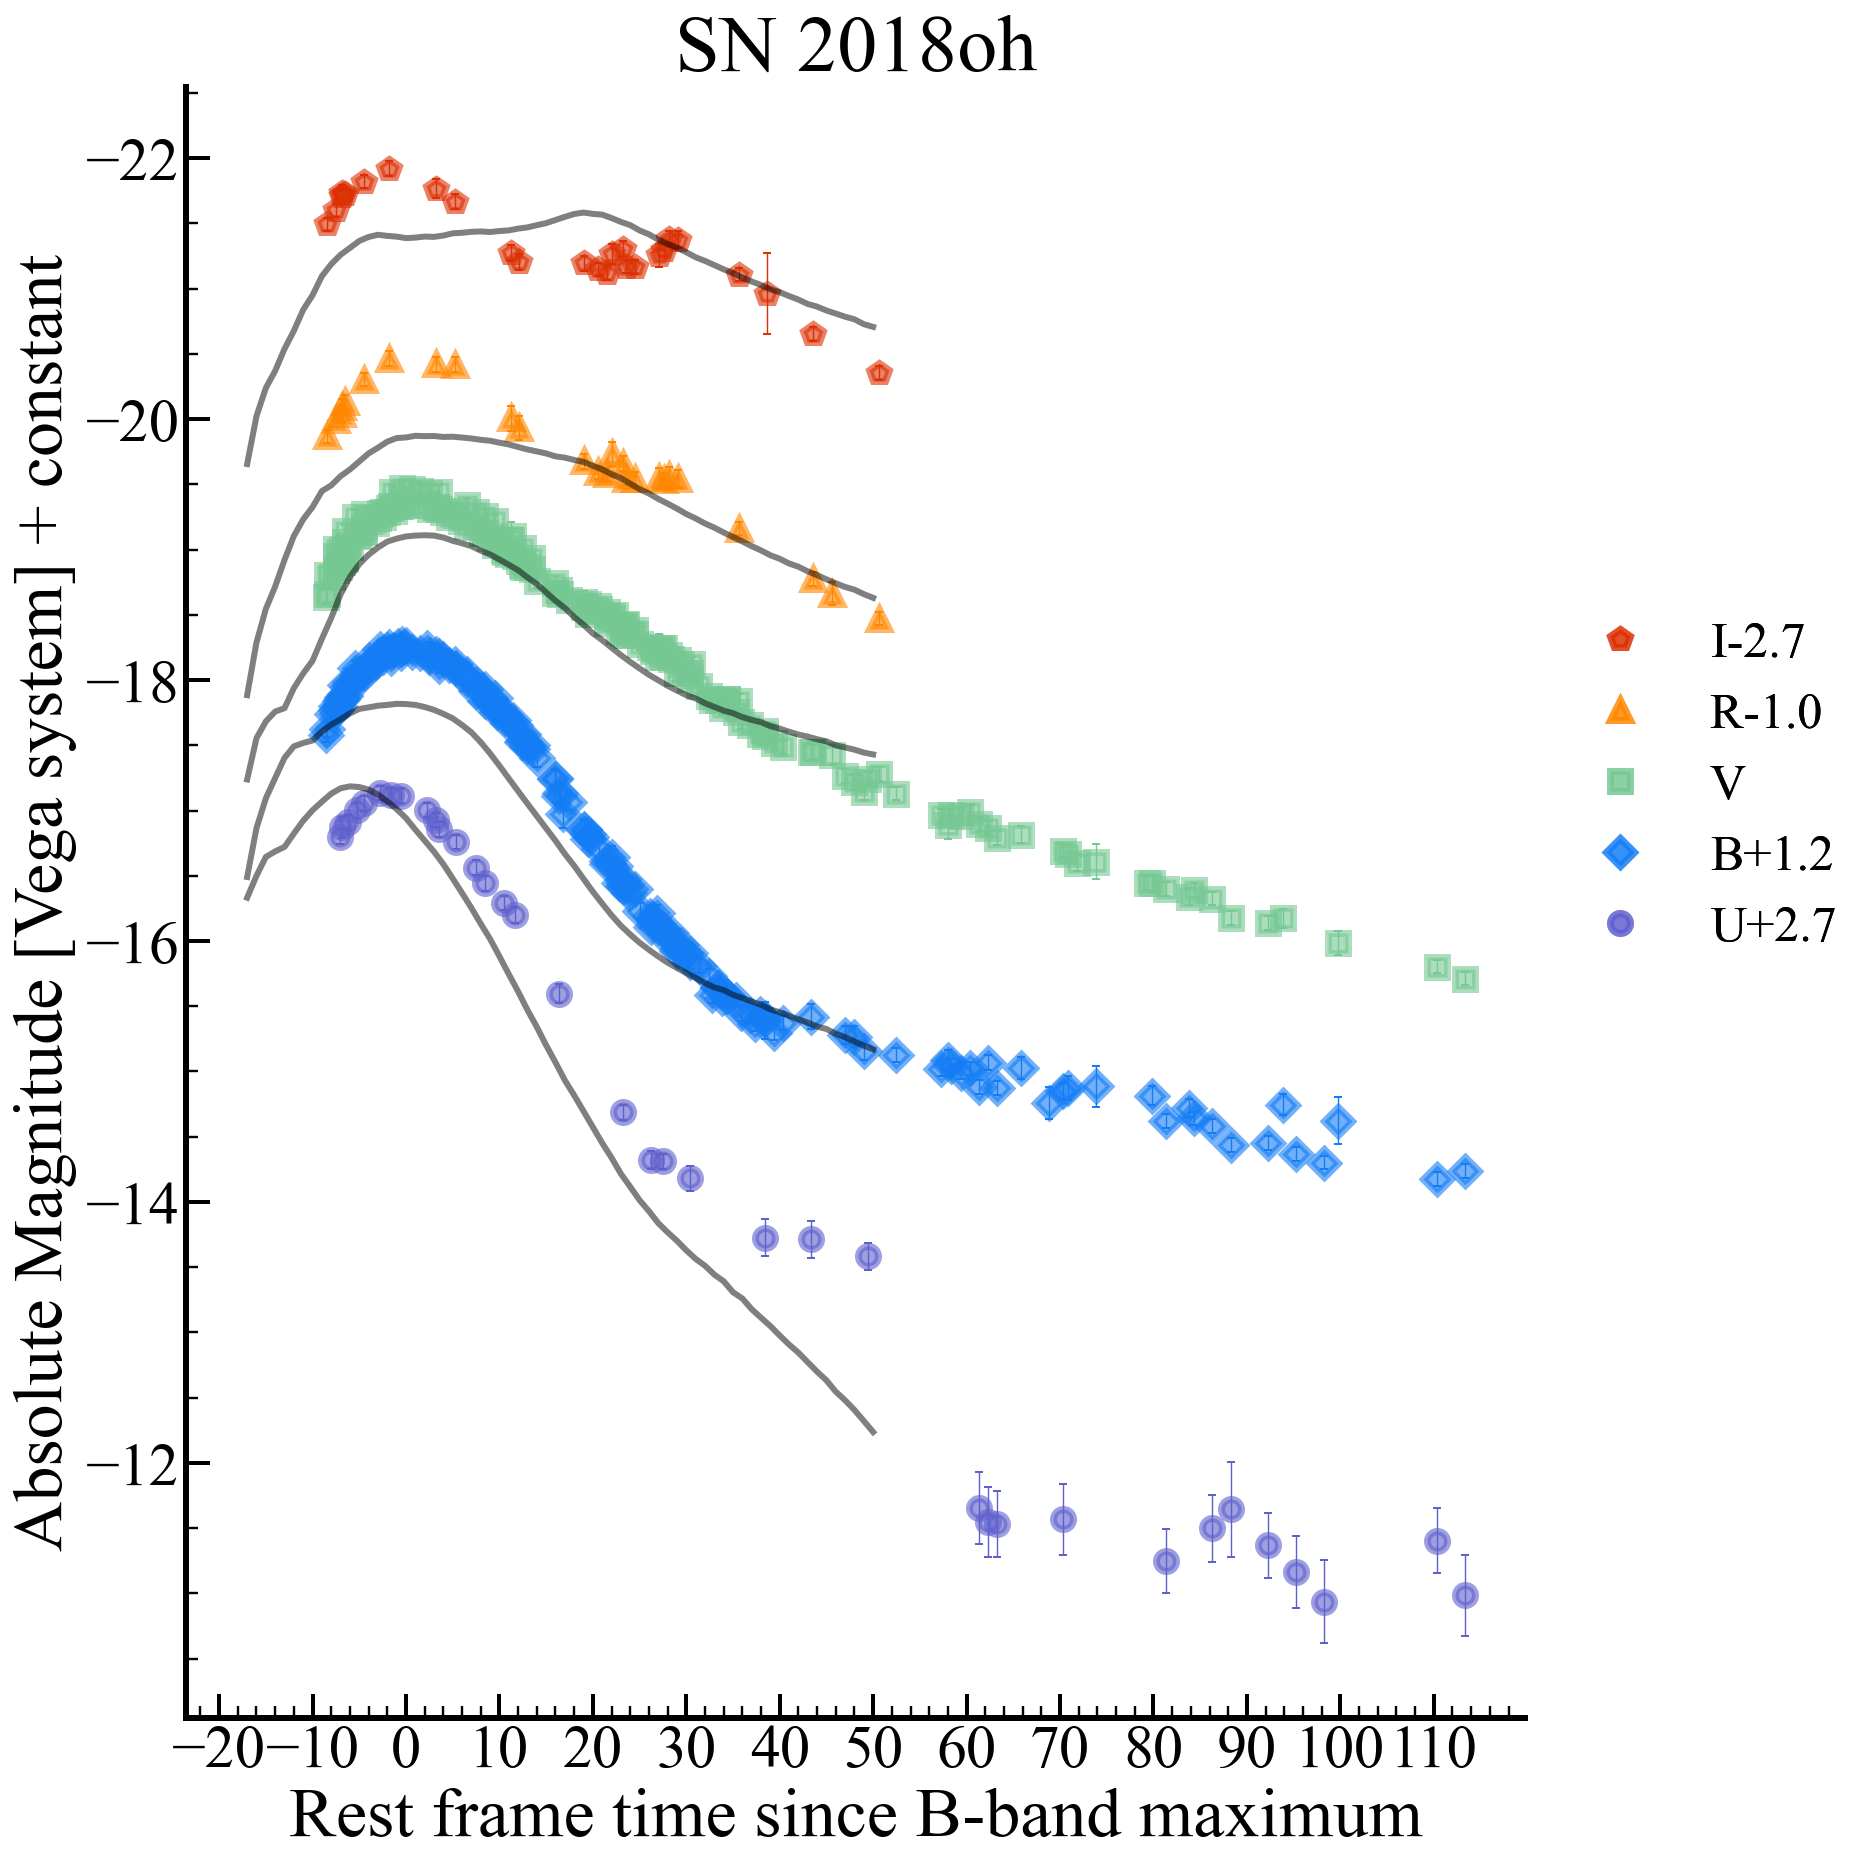

In [44]:
fig = plt.figure(figsize=(12, 15))
ax = fig.add_subplot(111)


plot_params('A', ax, ml_x = 10, mil_x = 2, ml_y = 2, mil_y = 0.5, invert=True)
legend_properties = {'size':25, 'weight':'book'}
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['axes.linewidth'] = 3


# B, I, R, U, V
offset = [+1.2, -2.7, -1.0, +2.7, +0.0]
#offset = [+1.2, +2.7, 0.0]
str_offset = ['+1.2', '-2.7', '-1.0 ', '+2.7', ' ']
#str_offset = ['+1.2', '+2.7', ' ']
color = ['#005F73', '#57CC99']
i = 0
line1 =[]
for band, band_df in flux_df_UBVRI.groupby('FILTER'):
    print (band)
    line1 += ax.plot(band_df['Phase'], band_df['AbsMag']+offset[i], mfc = filter_df.loc[band, 'Color'],
                    mec = filter_df.loc[band, 'Color'], markeredgewidth=3.5, 
                    marker = filter_df.loc[band, 'Marker'],  markersize = 10,
                    alpha = 0.6, ls = ' ', label = str(band) + str_offset[i])
                     
    ax.errorbar(band_df['Phase'], band_df['AbsMag']+offset[i], yerr = band_df['AbsErr'], fmt = '',
                c = filter_df.loc[band, 'Color'], ls = '', lw = 0.7, capsize=2, capthick=1,
                )
    line1.append(line1)
    
    i = i+1
    
# U(3), B(0), V(4), R(2), I(1)    
handles_1,labels_1 = ax.get_legend_handles_labels()    
handles_1 = [handles_1[1], handles_1[2], handles_1[4], handles_1[0], handles_1[3]]
#handles_1 = [handles_1[2], handles_1[0], handles_1[1]]
labels_1 = [labels_1[1], labels_1[2], labels_1[4], labels_1[0], labels_1[3]]
#labels_1 = [labels_1[2], labels_1[0], labels_1[1]]

legend_1 = ax.legend(handles_1,labels_1, frameon= False, 
                     fancybox = False, shadow = False, framealpha=0.3, facecolor = 'white', 
                     prop = legend_properties, bbox_to_anchor=(1.0, 0.7))

ax.add_artist(legend_1)    
    
ax.plot(sedona_lc1_df['Phase'], sedona_lc1_df['B_Vega']+1.2, color='black', linewidth=3.0, ls='-', alpha=0.5, dash_capstyle='round')    
ax.plot(sedona_lc1_df['Phase'], sedona_lc1_df['I_Vega']-2.7, color='black', linewidth=3.0, ls='-', alpha=0.5, dash_capstyle='round')    
ax.plot(sedona_lc1_df['Phase'], sedona_lc1_df['R_Vega']-1.0, color='black', linewidth=3.0, ls='-', alpha=0.5, dash_capstyle='round')    
ax.plot(sedona_lc1_df['Phase'], sedona_lc1_df['U_Vega']+2.7, color='black', linewidth=3.0, ls='-', alpha=0.5, dash_capstyle='round')    
ax.plot(sedona_lc1_df['Phase'], sedona_lc1_df['V_Vega']+0.0, color='black', linewidth=3.0, ls='-', alpha=0.5, dash_capstyle='round')    
    
#ax.set_ylabel('Absolute Magnitude [Vega system] + constant', fontsize = 35, fontname='Times New Roman')

for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize = 30)
    #tick.label1.set_fontweight('bold')
    
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize = 30)
    #tick.label1.set_fontweight('bold')
#ax.set_xlim(0, 65)    
#ax.set_ylim(-13.5, -23)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_ylabel('Absolute Magnitude [Vega system] + constant', fontsize = 35, fontname='Times New Roman')
ax.set_xlabel('Rest frame time since B-band maximum', fontsize = 35, fontname='Times New Roman')
ax.set_title('SN 2018oh', fontsize=40, fontname='Times New Roman')
#ax.legend(frameon= False, fancybox = False, shadow = False, facecolor = 'white', 
#        prop = legend_properties, framealpha=0.3,
#                    bbox_to_anchor = (0.25, 0.25))    
    

In [19]:
sedona_lc1_df

,Time,Lbol,Mbol,U,B,V,Cousins_R,Cousins_I,UVW1,UVM2,UVW2,Phase,U_Vega,B_Vega,V_Vega,R_Vega,I_Vega
2,2.5,2.603052e+43,-19.84128,-18.24184,-17.78012,-17.21780,-16.67385,-16.50526,NaN,NaN,NaN,-17.0,-19.03184,-17.69012,-17.23780,-16.88385,-16.95526
3,3.5,2.619832e+43,-19.84826,-18.40962,-18.15506,-17.53443,-17.07845,-16.87297,NaN,NaN,NaN,-16.0,-19.19962,-18.06506,-17.55443,-17.28845,-17.32297
4,4.5,2.684714e+43,-19.87482,-18.55397,-18.38319,-17.66233,-17.33421,-17.08807,NaN,NaN,NaN,-15.0,-19.34397,-18.29319,-17.68233,-17.54421,-17.53807
5,5.5,2.549849e+43,-19.81886,-18.59657,-18.53884,-17.73853,-17.50685,-17.22005,NaN,NaN,NaN,-14.0,-19.38657,-18.44884,-17.75853,-17.71685,-17.67005
6,6.5,2.313272e+43,-19.71314,-18.63102,-18.69351,-17.76427,-17.71085,-17.38813,NaN,NaN,NaN,-13.0,-19.42102,-18.60351,-17.78427,-17.92085,-17.83813
7,7.5,2.126504e+43,-19.62174,-18.73310,-18.78186,-17.91822,-17.89418,-17.52662,NaN,NaN,NaN,-12.0,-19.52310,-18.69186,-17.93822,-18.10418,-17.97662
8,8.5,1.999845e+43,-19.55507,-18.83186,-18.80780,-18.03076,-18.02166,-17.68814,NaN,NaN,NaN,-11.0,-19.62186,-18.71780,-18.05076,-18.23166,-18.13814
9,9.5,1.896640e+43,-19.49754,-18.91204,-18.82638,-18.12775,-18.11617,-17.79931,NaN,NaN,NaN,-10.0,-19.70204,-18.73638,-18.14775,-18.32617,-18.24931
10,10.5,1.848587e+43,-19.46967,-18.97729,-18.89526,-18.29594,-18.23829,-17.94565,NaN,NaN,NaN,-9.0,-19.76729,-18.80526,-18.31594,-18.44829,-18.39565
11,11.5,1.764730e+43,-19.41927,-19.03918,-18.94902,-18.45635,-18.28241,-18.03753,NaN,NaN,NaN,-8.0,-19.82918,-18.85902,-18.47635,-18.49241,-18.48753
